In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('secondary.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5035 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  5035 non-null   object
 1   review        5035 non-null   object
 2   score         5035 non-null   object
 3   real_date     5035 non-null   object
 4   year          5035 non-null   int64 
 5   month         5035 non-null   int64 
 6   type          4558 non-null   object
 7   dataset       4966 non-null   object
dtypes: int64(2), object(6)
memory usage: 314.8+ KB


C:\Users\jenny\AppData\Local\Temp/ipykernel_24888/3728096588.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('secondary.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


In [3]:
df[df['dataset'].isnull()]

,review_title,review,score,real_date,year,month,type,dataset
354,"세련된 트렌디 한 장소, 특히 밤에","홍대에 위치 하는 곳이나 낮이나 밤에 모두 볼 수 있습니다. 아, 일요일 밤에 가기...",4,2016년 10월,2016,10,가족,NaN
362,Q: // partygoer 입니다 scenester 하는 것이 오? 답변: 없습니...,"예, 마음이 넓은 것이 있는 곳이에요, 기대 하고, 한국인들이 만나는 어린 새 x ...",4,2016년 10월,2016,10,커플,NaN
397,"유명한, 놓칠 수 없는 위치","원하는 경우 아 독특한 한국 사람들과 편안한 경험인가, 서울 홍대 합니다. 에는 많...",5,2017년 1월,2017,1,가족,NaN
587,저는 여기에 있으니까요 - 가방을 도둑맞았어요!,"나는 이 곳 이었을 수도 하면서, 나는 여기에 가지고 있으니까요. 내 가방을 도둑맞...",1,2015년 4월,2015,4,커플,NaN
605,한 경험이었다.,"이곳은 꽤 넓은 장소, 하게, 특히 음식, 면 적어도 한 번은 곳, 먹고 싶은 것을...",4,2015년 5월,2015,5,친구,NaN
...,...,...,...,...,...,...,...,...
4469,큰 쇼핑 센터 및 아름다운 레스토랑,"이 멋진 산책, 쇼핑이나 식사 공간. 상점들이 많은 것은, 기존 항목 로컬 의류, ...",5,2016년 11월,2016,11,커플,NaN
4479,관광객들로 활기찬 쇼핑과 식사를 하고,인사동에 있는 항상 뭔가 가. 아 학교 밴드 또는 퍼레이드. 지난 일요일 에는 많은...,5,2016년 11월,2016,11,개인,NaN
4541,"할 수 있는 좋은 장소, 사람 구경, 쇼핑을 구입하고","저는 인사동 거리는 한국에 있는 동안 두 번, 한 번 또 변경다른 밤. 아침에 가서...",5,2017년 2월,2017,2,개인,NaN
4550,관광객 입니다. 그러나 이 작은 흥미로운 것입니다. 음식 & 쇼핑 및 문화.,안국역이나 아주 가까운 곳입니다. 관광객 입니다. 많은 관광객들은 장신구 와 선물 ...,3,2017년 2월,2017,2,가족,NaN


In [4]:
#결측치 데이터 지우기
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 5034
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_title  4966 non-null   object
 1   review        4966 non-null   object
 2   score         4966 non-null   object
 3   real_date     4966 non-null   object
 4   year          4966 non-null   int64 
 5   month         4966 non-null   int64 
 6   type          4496 non-null   object
 7   dataset       4966 non-null   object
dtypes: int64(2), object(6)
memory usage: 349.2+ KB


In [5]:
import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [6]:
tokenized_list2 = []
a=df['dataset'].values
for text in range(len(a)):
    tokenized_list2.append(tokenize_korean_text(a[text]))

In [12]:
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 4966
Total words: 123638
Vocab size: 4073


==== Coherence : c ====
Average: 0.420452329190448 
Per Topic: [0.45831183791160585, 0.4750361114740372, 0.452576145529747, 0.3932949960231781, 0.4139262616634369, 0.4249000161886215, 0.36065012514591216, 0.4026391290128231, 0.39477144181728363, 0.4418599814176559, 0.41365876495838166, 0.431261146068573, 0.4512355923652649, 0.4340789496898651, 0.43747536838054657, 0.4026843622326851, 0.42595771253108977, 0.4010525707155466, 0.3982108920812607, 0.39546517860144376]


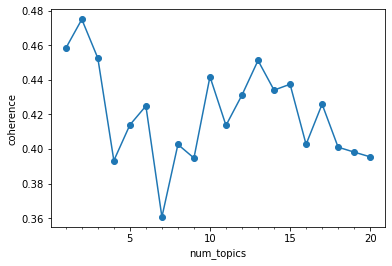

In [13]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [14]:
model = tp.DMRModel(k=6 , alpha=0.1, eta=0.01, min_df=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df['score'].values
value=tokenized_list2


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 4966
Total words: 123383
Vocab size: 3993
Topic #0	외국인, 명동, 관광객, 너무, 중국인, 사람, 롯데, 중국, 많고, 타워
Topic #1	명동, 재래시장, 서울, 방문, 가격, 롯데, 하지만, 백화점, 입구, 거리
Topic #2	많은, 좋은, 상점, 지역, 거리, 레스토랑, 장소, 사람, 모든, 서울
Topic #3	기념품, 좋은, 전통, 인사동, 한국, 가게, 많은, 상점, 지역, 예술
Topic #4	먹거리, 빈대떡, 광장시장, 홍대, 거리, 김밥, 외국인, 인사동, 구경, 육회
Topic #5	많은, 모든, 제품, 화장품, 좋은, 길거리, 가게, 경우, 상점, 시장


In [15]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 4966 docs, 123383 words
| Total Vocabs: 12149, Used Vocabs: 3993
| Entropy of words: 6.81926
| Entropy of term-weighted words: 7.51553
| Removed Vocabs: 있는 쇼핑 음식
| Metadata of docs and its distribution
|  5: 2119
|  4: 1887
|  3: 750
|  2: 161
|  1: 49
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.51077
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 0 (minimum collection frequency of words)
| min_df: 3 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 6 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of norma

In [16]:
#감성점수 계산
print('Topic distributions by score')

df2=pd.DataFrame()
score_labels=['1','2','3','4','5']
for i in score_labels:
    df2[i+'score']=model.get_topic_prior(i)
df2['total']=df2.sum(axis=1)

total_sum=df2['total'].values
gamsung_sum=0
gamsung_list=[]
for i in range(model.k):
    a=df2.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df2['re_score']=gamsung_list
df2=df2.round(3)
df2.head(20)

Topic distributions by score


,1score,2score,3score,4score,5score,total,re_score
0,0.013,0.346,0.079,0.091,0.065,0.593,2.745
1,0.065,0.022,0.021,0.036,0.049,0.192,2.906
2,0.079,0.044,0.060,0.163,0.232,0.577,3.736
3,0.046,0.084,0.068,0.086,0.144,0.428,3.465
4,0.043,0.250,0.108,0.093,0.077,0.570,2.845
5,0.104,0.028,0.016,0.119,0.151,0.418,3.443


In [17]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df2['word_list']=word_list
df2.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.013,0.346,0.079,0.091,0.065,0.593,2.745,"[외국인, 명동, 관광객, 너무, 중국인, 사람, 롯데, 중국, 많고, 타워]"
1,0.065,0.022,0.021,0.036,0.049,0.192,2.906,"[명동, 재래시장, 서울, 방문, 가격, 롯데, 하지만, 백화점, 입구, 거리]"
2,0.079,0.044,0.060,0.163,0.232,0.577,3.736,"[많은, 좋은, 상점, 지역, 거리, 레스토랑, 장소, 사람, 모든, 서울]"
3,0.046,0.084,0.068,0.086,0.144,0.428,3.465,"[기념품, 좋은, 전통, 인사동, 한국, 가게, 많은, 상점, 지역, 예술]"
4,0.043,0.250,0.108,0.093,0.077,0.570,2.845,"[먹거리, 빈대떡, 광장시장, 홍대, 거리, 김밥, 외국인, 인사동, 구경, 육회]"
5,0.104,0.028,0.016,0.119,0.151,0.418,3.443,"[많은, 모든, 제품, 화장품, 좋은, 길거리, 가게, 경우, 상점, 시장]"


In [18]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 외국인, 많아서, 외국, 너무, 다만
외국인	0.011584966443479061
명동	0.009888469241559505
관광객	0.008225594647228718
너무	0.00815234798938036
중국인	0.0078277001157403
사람	0.007041593082249165
롯데	0.006970975548028946
중국	0.006883651949465275
많고	0.006867139134556055
타워	0.005995613522827625

== Topic #1 ==
Labels: 박스, 있는, 롯데 신세계, 하더군요, 15분 정도
명동	0.008801567368209362
재래시장	0.006954737473279238
서울	0.006784574128687382
방문	0.005884564481675625
가격	0.005648896098136902
롯데	0.005630024243146181
하지만	0.005517150275409222
백화점	0.005516005214303732
입구	0.005420103203505278
거리	0.005406395066529512

== Topic #2 ==
Labels: 경우, 지역, 상점, 또한, 있는
많은	0.008510410785675049
좋은	0.007943409495055676
상점	0.007137754466384649
지역	0.007057731971144676
거리	0.0067858328111469746
레스토랑	0.006007560063153505
장소	0.005926324520260096
사람	0.0057771168649196625
모든	0.005760913714766502
서울	0.005548917688429356

== Topic #3 ==
Labels: 또한, 지역, 있는, 경우, 상점
기념품	0.00876918900758028
좋은	0.00830021221190691
전통	0.007238989230245352
인사동	0.006631402764

In [19]:
df3=pd.DataFrame()
df3['docs']=tokenized_list2
df3['score']=df['score'].values
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    4966 non-null   object
 1   score   4966 non-null   object
dtypes: object(2)
memory usage: 77.7+ KB


In [20]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)

In [21]:
df3['topic_num']=topic_num
df3[df3['topic_num'].isnull()]

,docs,score,topic_num
5,"[거리, 길거리, 젊은, 대학생, 겨울, 딱히, 대부분, 점포, 판매, 여성, 소매...",3,NaN
7,"[트렌디, 장소, 많은, 음식, 소매, 설루션, 특히, 야경, 젊고, 트렌디, 군중...",5,NaN
8,"[젊음, 자유, 사람, 너무, 많았으나, 좋은, 거리, 먹을, 거리, 많은, 특히,...",4,NaN
11,"[좋았을, 학교, 갔다, 바쁜, 홍익대학교, 주변, 동네, 적하, 펑키, 패션, 훌...",5,NaN
14,"[좋은, 경험, 작은, 커피숍, 식당, 가득한, 아니라면, 내부, 기관, 몇몇, 가...",4,NaN
...,...,...,...
4949,"[모든, 있다, 영화관, 쇼핑몰, 음식점, 호텔, 모든, 갖추어진, 가까워, 자주,...",5,NaN
4950,"[관광, 전망대, 굳이, 비싼, 가격, 주고, 필요, 없음, 롯데, 카드, 할인, ...",3,NaN
4955,"[도심, 한가운데, 즐기는, 놀이기구, 그러나, 실내, 만큼, 인구, 집도, 높고,...",4,NaN
4960,"[볼거리, 먹거리, 즐길, 거리, 많은, 볼거리, 먹거리, 즐길, 거리, 많은, 쇼...",5,NaN


In [22]:
df4=df3.groupby(['topic_num','score'])['docs']
print(df4.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1      22
1         0.0     2      52
2         0.0     3     150
3         0.0     4     185
4         0.0     5     128
5         1.0     1       1
6         1.0     2       1
7         1.0     3      17
8         1.0     4      27
9         1.0     5      32
10        2.0     1       3
11        2.0     2      21
12        2.0     3     101
13        2.0     4     416
14        2.0     5     541
15        3.0     1       2
16        3.0     2       9
17        3.0     3      89
18        3.0     4     251
19        3.0     5     314
20        4.0     1       6
21        4.0     2      32
22        4.0     3     158
23        4.0     4     310
24        4.0     5     332
25        5.0     1       3
26        5.0     2      12
27        5.0     3     112
28        5.0     4     336
29        5.0     5     409
